# **Instrument Cloning with Pix2Pix**
**Big Data Computing 2022-2023 | Davide Gabrielli | 1883616**


---


Create a model able to reproduce audio of an instrument learning from some samples of MIDI and corresponding audio.
Made in *Pytorch* using *Pyspark* and *Petastorm*. Dataset used is [Nsynth Dataset](https://magenta.tensorflow.org/datasets/nsynth#instrument-sources) from Magenta by Google.


# 1. **Dependencies Setup**
Download and import all the dependencies needed for the project.

## 1.1. **Pip installs**
Install missing dependencies.

In [ ]:
!pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade
!pip install pytorch-lightning

  Cloning https://github.com/PytorchLightning/lightning-bolts.git (to revision master) to /tmp/pip-req-build-2bl3_1gd
  Running command git clone --filter=blob:none --quiet https://github.com/PytorchLightning/lightning-bolts.git /tmp/pip-req-build-2bl3_1gd
  Resolved https://github.com/PytorchLightning/lightning-bolts.git to commit 70cc5f5c3bb9e993d7b96f0f49514ff6bb0bbc98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for lightning-bolts: filename=lightning_bolts-0.7.0-py3-none-any.whl size=303901 sha256=6f4eb5aac21869d1de141f089b1e8dad46718a63e279701fd17462c5283a1cb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0gqt0unl/wheels/1e/24/be/48c6a7a89feb08b86daf4b48c2b6a8fbb0bedaadbdccd1e758
Successfully built lightning-bolt

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=f84fe935075828eb4ff8eea85c36ab562cc9609ec6f47499b0c72ea8b62552e2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
!pip install petastorm[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install frechet_audio_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.6 MB/s eta 0:00:00


## 1.2. **Imports**
Import all dependencies.

### 1.2.1. Generic import

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# Default libs
import sys
import os
import math
import json
from typing import TypedDict
import shutil
from functools import partial
import random
import gc
# BD libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
# Audio libs
import librosa
from librosa import stft, istft, amplitude_to_db, db_to_amplitude
from scipy import signal
import soundfile as sf
# Ipython libs
from IPython.display import Audio
from IPython.display import display, clear_output
import ipywidgets as widgets
# File libs
import tarfile
from google.colab import drive
import requests

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# Disable interactive plots
plt.ioff()

Random Seed:  999


### 1.2.2. Pythorch Lightning import

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pl_bolts.models.gans import Pix2Pix

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

### 1.2.3. Pyspark import

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.torch.distributor import TorchDistributor
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.functions import col, pandas_udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2.4. Petastorm import

In [ ]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from petastorm.pytorch import BatchedDataLoader
from petastorm import TransformSpec

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2.5. Metrics import

In [ ]:
from frechet_audio_distance import FrechetAudioDistance

# 2. **Dataset Setup**
Download to Google Drive (if not present already) the archive containing the dataset and extract it into current session.

## 2.1. Connect to Drive
Mount Google Drive.

In [ ]:
GDRIVE_DIR = "/content/drive/"
GDRIVE_HOME_DIR = os.path.join(GDRIVE_DIR, "MyDrive")
GDRIVE_DATA_DIR = os.path.join(GDRIVE_HOME_DIR, "AudioModelling")

# Mount drive
drive.mount(GDRIVE_DIR, force_remount=True)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive/


## 2.2. Downloader Utilities
Define functions to download and extract dataset.

In [ ]:
"""
This function downloads a file from a specific URL directly to Google Drive.
"""
def get_data(dataset_url, dest, chunk_size=1024):
  # Check if file already exists
  if os.path.exists(dest):
    print(f"{dest} already exists.")
    return
  # Downloading file
  with requests.get(dataset_url, stream=True) as r:
      r.raise_for_status()
      with open(dest, "wb") as f:
          pbar = tqdm(total=int(r.headers["Content-Length"]), unit="B", unit_scale=True, unit_divisor=1024)
          for chunk in r.iter_content(chunk_size=8192):
              if chunk:  # filter out keep-alive new chunks
                  f.write(chunk)
                  pbar.update(len(chunk))

"""
This function extract a tar file.
"""
def extract_file(tar_path, dest_path, dataset_type):
  status_file = os.path.join(dest_path, f"extract_status_{dataset_type}.txt")
  # Check if already extracted
  if os.path.exists(status_file):
    print(f"Data already extracted.")
    return
  # Extract the tar file
  with tarfile.open(tar_path) as archive:
    archive.extractall(dest_path)
  # Write file to confirm extraction gone well
  with open(status_file, "w") as f:
    f.write("OK")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.3. Download Train Dataset
Download the train dataset and extract locally.

In [ ]:
TRAIN_TYPE="valid" # train, valid, test
DATASET_URL = f"http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-{TRAIN_TYPE}.jsonwav.tar.gz"
GDRIVE_DATA_TRAIN_ZIP = os.path.join(GDRIVE_DATA_DIR, DATASET_URL.split("/")[-1])

LOCAL_DATA_DIR = "/content"
LOCAL_DATA_TRAIN_ZIP = os.path.join(LOCAL_DATA_DIR, DATASET_URL.split("/")[-1])
DO_LOCAL_TRAIN = True

# Download the dataset in Google Drive
get_data(DATASET_URL, GDRIVE_DATA_TRAIN_ZIP)

if DO_LOCAL_TRAIN:
  # Clone dataset to local colab and extract it
  if not os.path.exists(LOCAL_DATA_TRAIN_ZIP):
    shutil.copyfile(GDRIVE_DATA_TRAIN_ZIP, LOCAL_DATA_TRAIN_ZIP)
  extract_file(LOCAL_DATA_TRAIN_ZIP, LOCAL_DATA_DIR, TRAIN_TYPE)
else:
  # Extract the dataset in Google Drive
  extract_file(GDRIVE_DATA_TRAIN_ZIP, GDRIVE_DATA_DIR, TRAIN_TYPE)
  os.makedirs(f"nsynth-{TRAIN_TYPE}/audio", exist_ok=True)
  shutil.copy(GDRIVE_DATA_DIR + f"/nsynth-{TRAIN_TYPE}/examples.json", f"nsynth-{TRAIN_TYPE}/examples.json")

## 2.4. Download Test Dataset
Download the test dataset and extract locally.

In [ ]:
TEST_TYPE="test" # train, valid, test
DATASET_URL = f"http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-{TEST_TYPE}.jsonwav.tar.gz"
GDRIVE_DATA_TEST_ZIP = os.path.join(GDRIVE_DATA_DIR, DATASET_URL.split("/")[-1])

LOCAL_DATA_DIR = "/content"
LOCAL_DATA_TEST_ZIP = os.path.join(LOCAL_DATA_DIR, DATASET_URL.split("/")[-1])
DO_LOCAL_TEST = True

# Download the dataset in Google Drive
get_data(DATASET_URL, GDRIVE_DATA_TEST_ZIP)

if DO_LOCAL_TEST:
  # Clone dataset to local colab and extract it
  if not os.path.exists(LOCAL_DATA_TEST_ZIP):
    shutil.copyfile(GDRIVE_DATA_TEST_ZIP, LOCAL_DATA_TEST_ZIP)
  extract_file(LOCAL_DATA_TEST_ZIP, LOCAL_DATA_DIR, TEST_TYPE)
else:
  # Extract the dataset in Google Drive
  extract_file(GDRIVE_DATA_TEST_ZIP, GDRIVE_DATA_DIR, TEST_TYPE)

## 2.5. Dataset Structure
The dataset has 11 (different instruments) × 3 (types).
<table>
  <tr>
    <td>
      <table>
        <thead>
          <tr>
            <th>Index</th>
            <th>ID</th>
          </tr>
        </thead>
        <tbody>
          <tr>
            <td>0</td>
            <td>bass</td>
          </tr>
          <tr>
            <td>1</td>
            <td>brass</td>
          </tr>
          <tr>
            <td>2</td>
            <td>flute</td>
          </tr>
          <tr>
            <td>3</td>
            <td>guitar</td>
          </tr>
          <tr>
            <td>4</td>
            <td>keyboard</td>
          </tr>
          <tr>
            <td>5</td>
            <td>mallet</td>
          </tr>
          <tr>
            <td>6</td>
            <td>organ</td>
          </tr>
          <tr>
            <td>7</td>
            <td>reed</td>
          </tr>
          <tr>
            <td>8</td>
            <td>string</td>
          </tr>
          <tr>
            <td>9</td>
            <td>synth_lead</td>
          </tr>
          <tr>
            <td>10</td>
            <td>vocal</td>
          </tr>
        </tbody>
      </table>
    </td>
    <td width="40%">
    </td>
    <td>
      <table>
        <thead>
          <tr>
            <th>Index</th>
            <th>ID</th>
          </tr>
        </thead>
        <tbody>
          <tr>
            <td>0</td>
            <td>acoustic</td>
          </tr>
          <tr>
            <td>1</td>
            <td>electronic</td>
          </tr>
          <tr>
            <td>2</td>
            <td>synthetic</td>
          </tr>
        </tbody>
      </table>
    </td>
  </tr>
</table>

In [ ]:
instruments = [ "bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal" ]
types = [ "acoustic", "electronic", "synthetic" ]

# selected_instrument = "flute_synthetic_000"
selected_instrument = "guitar_acoustic"

class DataJson(TypedDict):
  note: int
  sample_rate: int
  qualities: list[bool]
  pitch: int
  note_str: str
  instrument_family_str: str

train_dataroot = f"nsynth-{TRAIN_TYPE}/audio/"
test_dataroot = f"nsynth-{TEST_TYPE}/audio/"


# Load training dataset
data = json.load(open(f"nsynth-{TRAIN_TYPE}/examples.json"))
json_train_data: list[DataJson] = [x for k, x in data.items() if selected_instrument in x['instrument_str']]
print(f"For {selected_instrument} we have {len(json_train_data)} audio files in training set")

# Load test dataset
data = json.load(open(f"nsynth-{TEST_TYPE}/examples.json"))
json_test_data: list[DataJson] = [x for k, x in data.items() if selected_instrument in x['instrument_str']]
print(f"For {selected_instrument} we have {len(json_test_data)} audio files in test set")

# Sum all json data
json_data = json_train_data + json_test_data

del data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For guitar_acoustic we have 1482 audio files in training set
For guitar_acoustic we have 481 audio files in test set


# 3. **PySpark Setup**
Create Spark Context and Dataframe from the dataset.

## 3.1. Create Spark context
Init Spark.

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("AudioModelling").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Set a cache directory on DBFS FUSE for intermediate data.
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, "file:///dbfs/tmp/petastorm/cache")

## 3.2. Dataframe
Load JSON data as Dataframe.

In [ ]:
schema = t.StructType([
    t.StructField("note_str", t.StringType(), False),
    t.StructField("pitch", t.IntegerType(), False),
    t.StructField("velocity", t.IntegerType(), False),
    t.StructField("sample_rate", t.IntegerType(), False)
])

# Create DataFrame from JSON data
df = spark.read.json(spark.sparkContext.parallelize([json_data]))

# Extract desired columns
df = df.select(*[c for c in schema.names if c in df.columns])

# Create train, validation and test
df_train, df_val, df_test = df.randomSplit(weights=[0.8, 0.1, 0.1], seed=manualSeed)

# Display the DataFrame
df_train.show(5)
df_val.show(5)
df_test.show(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+--------------------+-----+--------+-----------+
|            note_str|pitch|velocity|sample_rate|
+--------------------+-----+--------+-----------+
|guitar_acoustic_0...|   21|      25|      16000|
|guitar_acoustic_0...|   21|      50|      16000|
|guitar_acoustic_0...|   21|      75|      16000|
|guitar_acoustic_0...|   21|     127|      16000|
|guitar_acoustic_0...|   22|      25|      16000|
+--------------------+-----+--------+-----------+
only showing top 5 rows

+--------------------+-----+--------+-----------+
|            note_str|pitch|velocity|sample_rate|
+--------------------+-----+--------+-----------+
|guitar_acoustic_0...|   22|      75|      16000|
|guitar_acoustic_0...|   22|     100|      16000|
|guitar_acoustic_0...|   24|      25|      16000|
|guitar_acoustic_0...|   26|      25|      16000|
|guitar_acoustic_0...|   28|     127|      16000|
+--------------------+-----+--------+-----------+
only showing top 5 rows

+--------------------+-----+--------+-----------+


## 3.3. Size of rows
Compute the size in byte of a row of the Dataframe.

In [ ]:
# Get average size of row
rows = df_train.collect()
avg_row_size = 0
min_row_size = float("inf")
max_row_size = 0
i = 0
for rw in rows:
  row_size = sys.getsizeof(rw[0:])
  avg_row_size += row_size
  min_row_size = min(min_row_size, row_size)
  max_row_size = max(max_row_size, row_size)
  i+=1
avg_row_size //= i
print(avg_row_size, min_row_size, max_row_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


72 72 72


# 4. **Audio Utilities**
Define some useful audio functions.

## 4.1. I/O Audio
Functions to load and save audio files.

In [ ]:
def load_audio(filename, custom_path="", sr=16000):
  audio_path = ""
  if custom_path != "":
    audio_path = custom_path + filename
  else:
    if os.path.exists(train_dataroot + filename):
      audio_path = train_dataroot + filename
    else:
      audio_path = test_dataroot + filename
  wav, _ = librosa.load(audio_path, sr=sr, mono=True)
  # librosa.util.normalize(wav)
  return wav

def save_audio(audio_path, spec, phase, sr=16000):
  # Reconstructed original audio
  spec_amp = db_to_amplitude(spec)
  wav_reconstruct = audioT.spec_to_wav(spec_amp, phase)
  wav_reconstruct = 2.*(wav_reconstruct - np.min(wav_reconstruct))/np.ptp(wav_reconstruct)-1
  sf.write(audio_path, wav_reconstruct, sr)

## 4.2. Show Spectrogram and Audio
Function to show audio and spectrograms in jupyter cells.

In [ ]:
def show_spec_and_audio(spec, phase, sr=16000):
  # Sine audio by midi spec
  plt.figure()
  librosa.display.specshow(spec, cmap=None, y_axis='linear', x_axis='time')
  plt.colorbar()
  plt.show()

  # Reconstructed original audio
  spec_amp = db_to_amplitude(spec)
  wav_reconstruct = audioT.spec_to_wav(spec_amp, phase)
  display(Audio(wav_reconstruct, rate=sr))

## 4.3. Generate Audio from Midi
Function to generate audio from midi information (sawtooth or sinewave).

In [ ]:
def midi_to_audio(synth_type, pitch, velocity, duration=2, sr=16000):
  freq = 440*(2**((pitch-69)/12))
  velocity /= 127
  t = np.linspace(0., duration, int(sr * duration))
  if synth_type == "sawtooth":
    sample = signal.sawtooth(freq * 2. * np.pi * t ) * velocity
  elif synth_type == "sinewave":
    sample = np.sin(freq * 2. * np.pi * t ) * velocity
  else:
    raise Exception("Invalid synth_type for midi_to_audio")
  return sample

Audio(midi_to_audio("sawtooth", 70, 127), rate=16000, normalize=False)

## 4.4. Audio-Spectrogram conversion
Functions to convert audio signal to spectrogram and viceversa.

guitar_acoustic_015-039-100


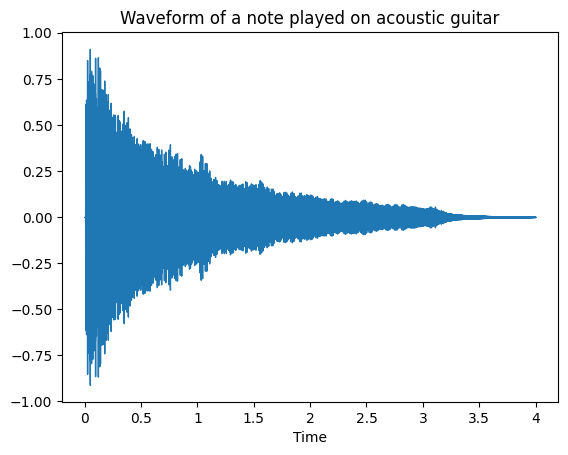

Original audio and midi audio synthesized


Spectrogram and inverse spectrogram to get original audio and midi audio synthesized back


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


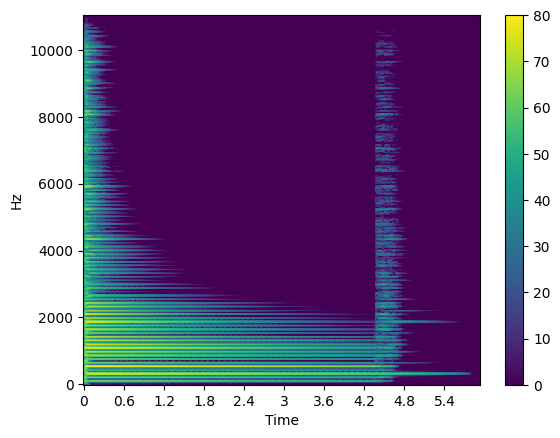

/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


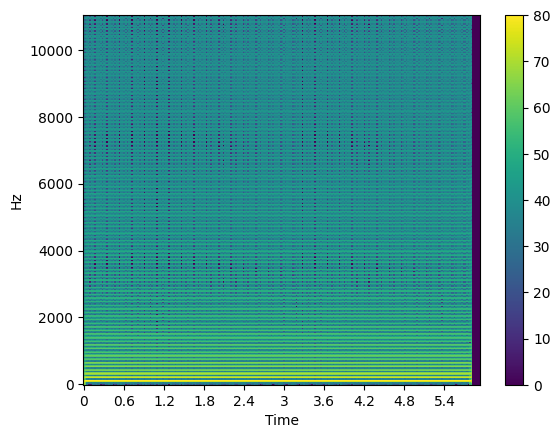

In [ ]:
class AudioTransform():
  def __init__(self):
    super().__init__()
    self.n_fft = 1024 # 4096
    self.hop_length = self.n_fft//4
    self.window = np.hanning(self.n_fft)

  def wav_to_spec(self, wav, sr=16000):
    # Transform audio to spec
    S = stft(wav, n_fft=self.n_fft, hop_length=self.hop_length, window=self.window)
    S, phase = np.abs(S), np.angle(S)
    # Create a (h=2x, w=x) size array
    blank_column = np.zeros((S.shape[0], 5))
    S = np.append(S, blank_column, axis=1)[:512]
    phase = np.append(phase, blank_column, axis=1)[:512]
    # Get amplitude
    S = amplitude_to_db(S, ref=np.max) + 80
    return S, phase

  def spec_to_wav(self, spec, phase, sr=16000):
    # Transform spec to audio
    spec = spec * np.exp(1j*phase)
    wav = istft(spec, n_fft=self.n_fft, hop_length=self.hop_length, window=self.window)
    return wav

# Load audio from file
midi_item = json_train_data[-7]
print(midi_item["note_str"])
filename = midi_item["note_str"] + ".wav"
wav_orig = load_audio(filename, sr=midi_item["sample_rate"])

plt.figure()
plt.title("Waveform of a note played on acoustic guitar")
librosa.display.waveshow(wav_orig, sr=midi_item["sample_rate"])
plt.show()

# Load midi info from file
duration = len(wav_orig)/midi_item["sample_rate"]
wav_midi = midi_to_audio("sawtooth", midi_item["pitch"], midi_item["velocity"], duration, midi_item["sample_rate"])

print("Original audio and midi audio synthesized")
# Original audio
display(Audio(wav_orig, rate=midi_item["sample_rate"]))
# Sine audio by midi
display(Audio(wav_midi, rate=midi_item["sample_rate"]))

audioT = AudioTransform()

print("Spectrogram and inverse spectrogram to get original audio and midi audio synthesized back")
# Original audio spec
spec_orig, phase = audioT.wav_to_spec(wav_orig, midi_item["sample_rate"])
show_spec_and_audio(spec_orig, phase)
# Sine audio by midi spec
spec_midi, phase = audioT.wav_to_spec(wav_midi, midi_item["sample_rate"])
show_spec_and_audio(spec_midi, phase)

# 5. **Model Utilities**
Define some useful function to train and test the model.

## 5.1. Patch Splitting
Function to split/merge audio spectrogram into two parts (high frequencies and low frequencies)

In [ ]:
def split_low_high_freq(spectrum):
    """
    Split in half the 2d spectrum and add as new dimension.

    Args:
      spectrum: shape (h, w) where h=2*w

    Return:
      spectrum_3d: shape (2, w, w)
    """
    h, w = spectrum.shape
    # Check if h is two times w
    if (h!=2*w):
      raise Exception("Invalid array")
    spectrum_3d = torch.reshape(spectrum, (2,w,w))
    return spectrum_3d

def merge_low_high_freq(spectrum_3d):
    """
    Merge the splitted spectrum and remove third dimension.

    Args:
      spectrum_3d: shape (2, w, w)

    Return:
      spectrum: shape (h, w) where h=2*w
    """
    x, h, w = spectrum_3d.shape
    spectrum = torch.reshape(spectrum_3d, (w*2,w))
    return spectrum

def split_remove_high_freq(spectrum):
    """
    Split in half the 2d spectrum, add as new dimension and remove the high frequency part.

    Args:
      spectrum: shape (h, w) where h=2*w

    Return:
      spectrum_3d: shape (1, w, w)
    """
    spectrum_3d = split_low_high_freq(spectrum)[0][None]
    return spectrum_3d

def recreate_high_freq(spectrum_3d):
    """
    Recreate the high frequency part of the spectrum and remove third dimension.

    Args:
      spectrum_3d: shape (1, w, w)

    Return:
      spectrum: shape (h, w) where h=2*w and the top of the matrix is full of zeros
    """
    x, h, w = spectrum_3d.shape
    zeros_tensor = torch.zeros(1, h, w)
    spectrum = torch.cat((spectrum_3d, zeros_tensor), dim=0)
    return spectrum

n = 4
values = [i for i in range(-16,16)]
arr = [values[n*i:n*(i+1)] for i in range(len(values)//n)]
x = torch.tensor(arr)
print("Original:\n", x, x.shape)
x = split_low_high_freq(x)
print("After Splitting:\n", x, x.shape)
x = merge_low_high_freq(x)
print("After Merging:\n", x, x.shape)
x = split_remove_high_freq(x)
print("After Removing High Frequencies:\n", x, x.shape)
x = recreate_high_freq(x)
print("After Recreating (Zeros) High Frequencies:\n", x, x.shape)

Original:
 tensor([[-16, -15, -14, -13],
        [-12, -11, -10,  -9],
        [ -8,  -7,  -6,  -5],
        [ -4,  -3,  -2,  -1],
        [  0,   1,   2,   3],
        [  4,   5,   6,   7],
        [  8,   9,  10,  11],
        [ 12,  13,  14,  15]]) torch.Size([8, 4])
After Splitting:
 tensor([[[-16, -15, -14, -13],
         [-12, -11, -10,  -9],
         [ -8,  -7,  -6,  -5],
         [ -4,  -3,  -2,  -1]],

        [[  0,   1,   2,   3],
         [  4,   5,   6,   7],
         [  8,   9,  10,  11],
         [ 12,  13,  14,  15]]]) torch.Size([2, 4, 4])
After Merging:
 tensor([[-16, -15, -14, -13],
        [-12, -11, -10,  -9],
        [ -8,  -7,  -6,  -5],
        [ -4,  -3,  -2,  -1],
        [  0,   1,   2,   3],
        [  4,   5,   6,   7],
        [  8,   9,  10,  11],
        [ 12,  13,  14,  15]]) torch.Size([8, 4])
After Removing High Frequencies:
 tensor([[[-16, -15, -14, -13],
         [-12, -11, -10,  -9],
         [ -8,  -7,  -6,  -5],
         [ -4,  -3,  -2,  -1]]]) t

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5.2. Custom Act
Custom activation functions and normalization function in range [0, +80].

In [ ]:
class CustomTanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return nn.functional.tanh(x) * 40 + 40

class CustomSigmoid(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return nn.functional.sigmoid(x) * 80

class Norm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Calculate the current minimum and maximum values of the matrix
        x_min = torch.min(x)
        x_max = torch.max(x)

        # Normalize the matrix to the range [0, 1]
        x = (x - x_min) / (x_max - x_min)

        x *= 80
        return x

customTanh = CustomTanh()
norm = Norm()
for i in range(1):
  m = torch.rand((8,2,256,256)).to("cuda")
  m = customTanh.forward(m)
  print(torch.max(m), torch.min(m))
  m = norm.forward(m)
  print(torch.max(m), torch.min(m))

tensor(70.4638, device='cuda:0') tensor(40.0001, device='cuda:0')
tensor(80., device='cuda:0') tensor(0., device='cuda:0')


## 5.3. Petastorm + Pytorch integration
Integration of Petastorm converter and transform specs with Pytorch.

### 5.3.1. Converter
Define converter from Spark Dataframe.

In [ ]:
converter_train = make_spark_converter(df_train, parquet_row_group_size_bytes=avg_row_size*10)
converter_val = make_spark_converter(df_val, parquet_row_group_size_bytes=avg_row_size*10)
converter_test = make_spark_converter(df_test, parquet_row_group_size_bytes=avg_row_size*10)

### 5.3.2. Transform Spec
Defining function to apply on batch of data.

In [ ]:
def audio_to_spec(training: bool, synth_type, df_batch: "pd.Dataframe"):
  # Load audios
  wavs = df_batch["note_str"].map(lambda filename: load_audio(filename + ".wav", sr=df_batch["sample_rate"][0]))
  # Get midi_args
  midi_args = [(df_batch["pitch"][i], df_batch["velocity"][i], len(wav_orig)/df_batch["sample_rate"][i], df_batch["sample_rate"][i]) for i, wav_orig in enumerate(wavs)]
  # Convert to spectrum
  spec_orig, phase_orig = zip(*wavs.map(lambda wav_orig: audioT.wav_to_spec(wav_orig)))
  # Synth midi audios
  wavs = list(map(lambda args: midi_to_audio(synth_type, args[0], args[1], args[2], args[3]), midi_args))
  # Convert to spectrum
  spec_midi, phase_midi = zip(*map(lambda wav_midi: audioT.wav_to_spec(wav_midi), wavs))
  # Tensors
  spec_orig = list(map(lambda spec: torch.tensor(spec, dtype=torch.float32), spec_orig))
  spec_midi = list(map(lambda spec: torch.tensor(spec, dtype=torch.float32), spec_midi))
  # Zero padding to make it a square
  spec_orig = list(map(lambda spec: np.array(split_remove_high_freq(spec)), spec_orig)) # Take only the half with meaningful signal
  spec_midi = list(map(lambda spec: np.array(split_remove_high_freq(spec)), spec_midi)) # Take only the half with meaningful signal
  phase_orig = list(phase_orig)
  phase_midi = list(phase_midi)
  # Select only the two columns
  if training:
    df_batch = pd.DataFrame(list(zip(spec_orig, spec_midi)), columns=["spec_orig", "spec_midi"])
  else:
    df_batch = pd.DataFrame(list(zip(spec_orig, spec_midi, phase_orig, phase_midi)), columns=["spec_orig", "spec_midi", "phase_orig", "phase_midi"])
  # del wavs, spec_orig, phase_orig, spec_midi, phase_midi
  return df_batch


def get_transform_spec(training=True, synth_type="sawtooth"):
  # Define the transform to apply to the batch extracted from dataset
  edit_fields = [('spec_orig', torch.float32, (1, 256, 256), False), ('spec_midi', torch.float32, (1, 256, 256), False)]
  fields = ['spec_orig', 'spec_midi']
  if not training:
     fields += ["phase_orig", "phase_midi"]
     edit_fields += [('phase_orig', np.float32, (512, 256), False), ('phase_midi', np.float32, (512, 256), False)]
  # Load the data and transform it
  return TransformSpec(partial(audio_to_spec, training, synth_type),
                       edit_fields=edit_fields,
                       selected_fields=fields)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 5.3.3. Trainer fix
Small fix in order to use the Pytorch Lightning trainer module.

In [ ]:
class PetastormDataloaderFix(Callback):
  def __init__(self, max_epochs, batches_for_epoch, batch_size, model):
    super().__init__()
    self.max_epochs = max_epochs
    self.batches_for_epoch = batches_for_epoch
    self.batch_size = batch_size
    self.epoch = 0
    self.batches = 0
    self.pbar = tqdm(total=self.batches_for_epoch, desc=f"Epoch: {self.epoch}", leave=True, position=0)
    self.model = model

  def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    # Update pbar
    self.batches += 1
    prev_epoch = self.epoch
    self.epoch = self.batches // self.batches_for_epoch
    self.pbar.update()
    if prev_epoch < self.epoch:
      self.pbar.close()
      self.pbar = tqdm(total=self.batches_for_epoch, desc=f"Epoch: {self.epoch}", leave=True, position=0)
      # Validate model
      if self.epoch % (self.max_epochs // 10) == 0:
        mean = 0
        i = 1
        with converter_val.make_torch_dataloader(num_epochs=1, transform_spec=get_transform_spec(training=True, synth_type=synth_type), batch_size=self.batch_size, workers_count=2) as val_dataloader:
          val_dataloader_iter = iter(val_dataloader)
          for i, pd_batch in tqdm(enumerate(val_dataloader_iter), position=0, leave=True):
            mean += self.model.test_step(pd_batch, 0)
          print(f"Validation: {mean/(i+1)}")

  def on_fit_end(self, trainer, pl_module):
    self.pbar.close()

### 5.3.4. Train/test step
Function for the training/testing step.

In [ ]:
# Custom training function selecting the data from the dataframe
def custom_training_step(self, pd_batch, batch_idx, optimizer_idx):
  real, condition = pd_batch['spec_orig'], pd_batch['spec_midi']
  loss = None
  if optimizer_idx == 0:
      loss = self._disc_step(real, condition)
      self.log("PatchGAN Loss", loss)
  elif optimizer_idx == 1:
      loss = self._gen_step(real, condition)
      self.log("Generator Loss", loss)
  return loss

def custom_test_step(self, pd_batch, batch_idx, optimizer_idx=0):
  real, condition = pd_batch['spec_orig'].to("cuda"), pd_batch['spec_midi'].to("cuda")
  loss = None
  if optimizer_idx == 0:
      loss = self._disc_step(real, condition)
      self.log("PatchGAN Loss", loss)
  elif optimizer_idx == 1:
      loss = self._gen_step(real, condition)
      self.log("Generator Loss", loss)
  return loss

## 5.4. Training loop definition
Function for the training process.

In [ ]:
def main_training_loop(model, num_tasks, num_proc_per_task):
  # add imports inside pl_train for pickling to work
  from torch import optim, nn, utils, Tensor
  from torchvision import datasets, transforms
  import pytorch_lightning as pl

  # train the model
  if num_tasks == 1 and num_proc_per_task == 1:
    kwargs = {}
  else:
    kwargs = {"strategy" : "ddp"}

  tot_batches=df_train.count()
  batch_size=min(150, tot_batches)
  lim_batches=math.ceil(tot_batches/batch_size)
  epochs=100

  petastormDataloaderFix = PetastormDataloaderFix(epochs, lim_batches, batch_size, model)
  trainer = pl.Trainer(accelerator="gpu", devices=num_proc_per_task, num_nodes=num_tasks, max_epochs=epochs, reload_dataloaders_every_n_epochs=1, logger=False, enable_progress_bar=False, callbacks=[petastormDataloaderFix], **kwargs)

  with converter_train.make_torch_dataloader(num_epochs=epochs, transform_spec=get_transform_spec(training=True, synth_type=synth_type), batch_size=batch_size) as train_dataloader:
    train_dataloader_iter = iter(train_dataloader)
    trainer.fit(model, train_dataloaders=train_dataloader_iter)

  return model, trainer.checkpoint_callback.best_model_path

def train_model(model, models_path, model_name):
  gc.collect()
  NUM_TASKS = 1
  NUM_PROC_PER_TASK = 1

  if os.path.exists(f"{models_path}/{model_name}.ckpt"):
    model = Pix2Pix.load_from_checkpoint(f"{models_path}/{model_name}.ckpt")
  else:
    model, ckpt_path = main_training_loop(model, NUM_TASKS, NUM_PROC_PER_TASK)
    shutil.copyfile(ckpt_path, f"{models_path}/{model_name}.ckpt")
  return model

## 5.5. Testing model definition
Function for the testing process.

In [ ]:
def test_model(model, model_name):
  with converter_test.make_torch_dataloader(transform_spec=get_transform_spec(training=False, synth_type=synth_type), num_epochs=1, batch_size=1, workers_count=1) as test_dataloader:
    test_dataloader_iter = iter(test_dataloader)
    n_to_show = 1
    norm = Norm()
    with tqdm(total=df_test.count(), position=0, leave=True) as pbar:
      for i, pd_batch in tqdm(enumerate(test_dataloader_iter), position=0, leave=True):
        pbar.update()
        # Get data
        spec_orig, spec_midi = pd_batch['spec_orig'][0], pd_batch['spec_midi'][0]
        phase_orig, phase_midi = pd_batch['phase_orig'][0].numpy(), pd_batch['phase_midi'][0].numpy()

        # Generate from data
        data = spec_midi.unsqueeze(dim=0).to("cuda") # Create batch with size one
        generated_spec = model.to("cuda").gen(data).cpu().detach()[0] # Take first element of the batch
        # Normalize it
        generated_spec = norm(generated_spec)
        generated_spec = merge_low_high_freq(recreate_high_freq(generated_spec)).numpy()
        # Original source sample
        spec_midi = merge_low_high_freq(recreate_high_freq(spec_midi)).numpy()
        # Original dest sample
        spec_orig =  merge_low_high_freq(recreate_high_freq(spec_orig)).numpy()

        # Save original audio if not saved
        os.makedirs("original", exist_ok=True)
        if not os.path.exists(f"original/{i}.wav"):
          save_audio(f"original/{i}.wav", spec_orig, phase_orig)

        # Save result of the model
        os.makedirs(f"output_{model_name}", exist_ok=True)
        save_audio(f"output_{model_name}/{i}.wav", generated_spec, phase_orig)

        # Show
        if n_to_show > 0:
          print(f"Original audio:")
          show_spec_and_audio(spec_orig, phase_orig)
          print(f"Midi audio:")
          show_spec_and_audio(spec_midi, phase_midi)
          print(f"Generated audio:")
          show_spec_and_audio(generated_spec, phase_orig)
          n_to_show -= 1
    del test_dataloader

# 6. **Models**
Train and test individually each model.

In [ ]:
models = ["sawtooth_tanh", "sawtooth_sigmoid", "sinewave_tanh", "sinewave_sigmoid"]
models_path = GDRIVE_DATA_DIR + "/models"
os.makedirs(models_path, exist_ok=True)

## 6.1. Sawtooth synth + Tanh
Model using *sawtooth reconstruction of midi* information as input spectrum of the *Pix2Pix* and a *tanh activation* function for the output of the generator.

### 6.1.1. Model initialization

In [ ]:
synth_type = "sawtooth"
model_name = models[0]
pix2pix_saw_tan = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
pix2pix_saw_tan.training_step = custom_training_step.__get__(pix2pix_saw_tan, Pix2Pix) # Replace training function
pix2pix_saw_tan.test_step = custom_test_step.__get__(pix2pix_saw_tan, Pix2Pix) # Replace training function
pix2pix_saw_tan.gen.tanh = CustomTanh()

<ipython-input-97-f1030d88fe58>:3: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  pix2pix_saw_tan = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.gen = Generator(in_channels, out_channels)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/components.py:84:

### 6.1.2. Start training

In [ ]:
pix2pix_saw_tan = train_model(pix2pix_saw_tan, models_path, model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is

### 6.1.3. Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/200 [00:03<10:43,  3.23s/it]

Original audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


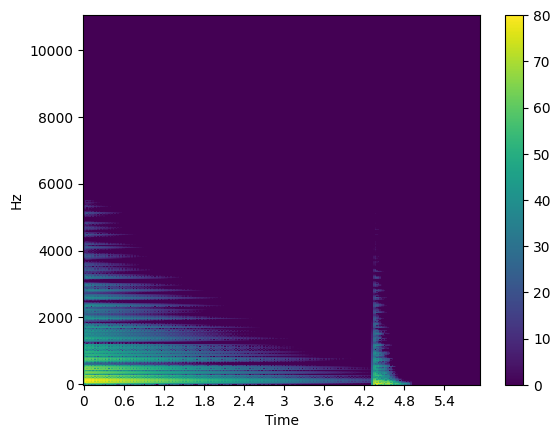

Midi audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


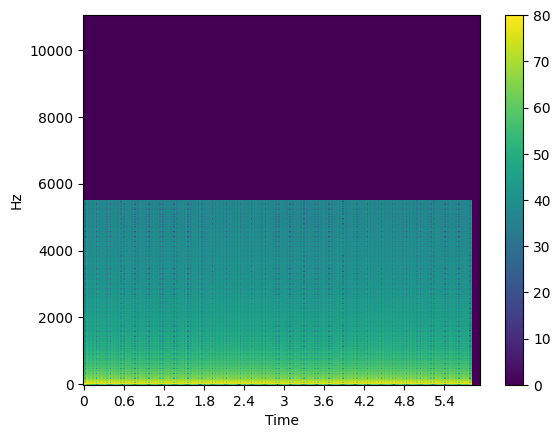

Generated audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


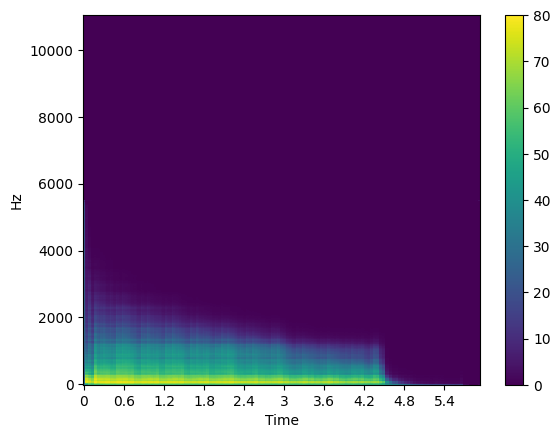

200it [00:34,  5.81it/s]
100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


In [ ]:
test_model(pix2pix_saw_tan, model_name)

## 6.2. Sawtooth synth + Sigmoid
Model using *sawtooth reconstruction of midi* information as input spectrum of the *Pix2Pix* and a *sigmoid activation* function for the output of the generator.

### 6.2.1. Model initialization

In [ ]:
synth_type = "sawtooth"
model_name = models[1]
pix2pix_saw_sig = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
pix2pix_saw_sig.training_step = custom_training_step.__get__(pix2pix_saw_sig, Pix2Pix) # Replace training function
pix2pix_saw_sig.test_step = custom_test_step.__get__(pix2pix_saw_sig, Pix2Pix) # Replace training function
pix2pix_saw_sig.gen.tanh = CustomSigmoid()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-100-bb7757986902>:3: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  pix2pix_saw_sig = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other 

### 6.2.2. Start training

In [ ]:
pix2pix_saw_sig = train_model(pix2pix_saw_sig, models_path, model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is

### 6.2.3. Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/200 [00:03<10:11,  3.07s/it]/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


Original audio:


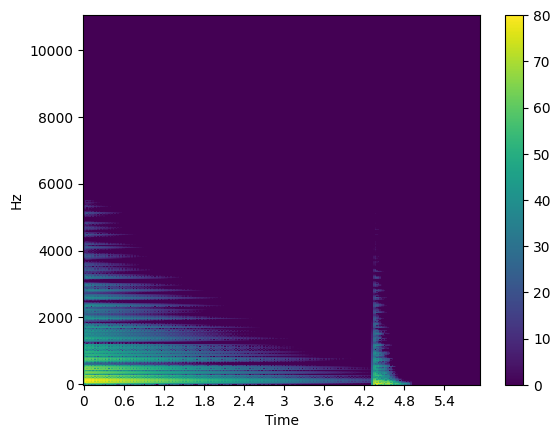

Midi audio:


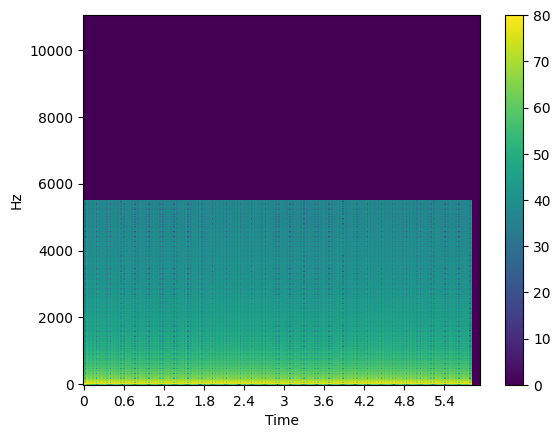

Generated audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


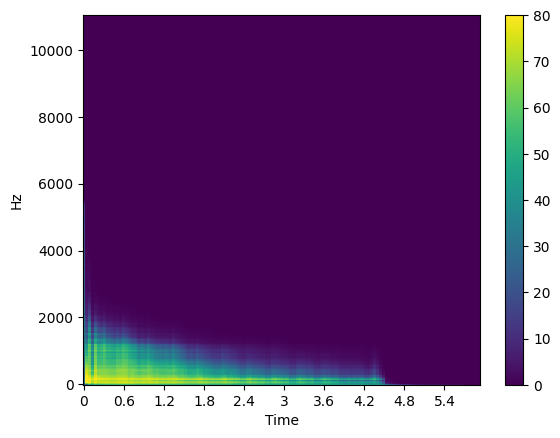

200it [00:32,  6.15it/s]
100%|██████████| 200/200 [00:32<00:00,  6.15it/s]


In [ ]:
test_model(pix2pix_saw_sig, model_name)

## 6.3. Sinewave synth + Tanh
Model using *sinewave reconstruction of midi* information as input spectrum of the *Pix2Pix* and a *tanh activation* function for the output of the generator.

### 6.3.1. Model initialization

In [ ]:
synth_type = "sinewave"
model_name = models[2]
pix2pix_sin_tan = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
pix2pix_sin_tan.training_step = custom_training_step.__get__(pix2pix_sin_tan, Pix2Pix) # Replace training function
pix2pix_sin_tan.test_step = custom_test_step.__get__(pix2pix_sin_tan, Pix2Pix) # Replace training function
pix2pix_sin_tan.gen.tanh = CustomTanh()

<ipython-input-103-29dc94ad2f7d>:3: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  pix2pix_sin_tan = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.gen = Generator(in_channels, out_channels)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/components.py:84

### 6.3.2. Start training

In [ ]:
pix2pix_sin_tan = train_model(pix2pix_sin_tan, models_path, model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is

### 6.3.3. Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/200 [00:03<10:52,  3.28s/it]/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


Original audio:


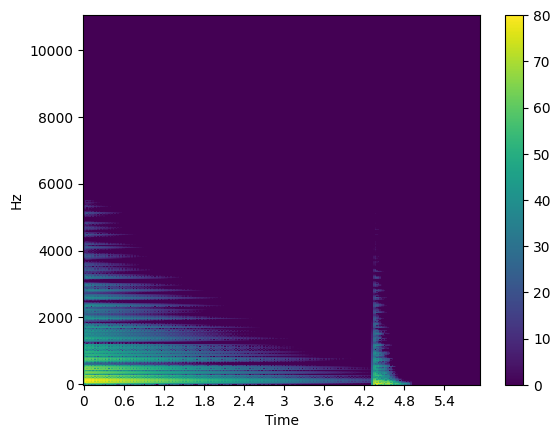

Midi audio:


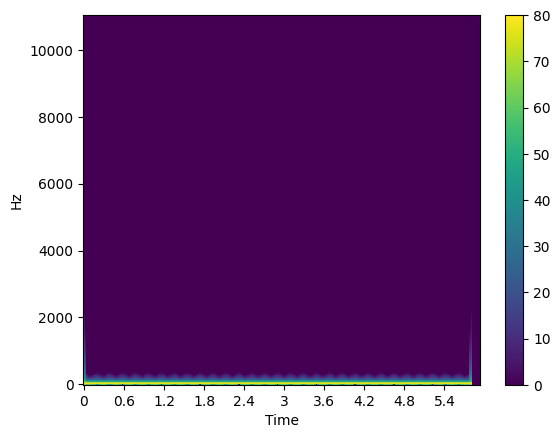

Generated audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


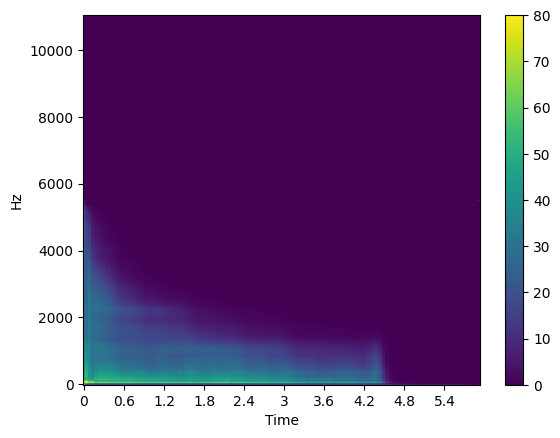

200it [00:29,  6.76it/s]
100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


In [ ]:
test_model(pix2pix_sin_tan, model_name)

## 6.4. Sinewave synth + Sigmoid
Model using *sinewave reconstruction of midi* information as input spectrum of the *Pix2Pix* and a *sigmoid activation* function for the output of the generator.

### 6.4.1. Model initialization

In [ ]:
synth_type = "sinewave"
model_name = models[3]
pix2pix_sin_sig = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
pix2pix_sin_sig.training_step = custom_training_step.__get__(pix2pix_sin_sig, Pix2Pix) # Replace training function
pix2pix_sin_sig.test_step = custom_test_step.__get__(pix2pix_sin_sig, Pix2Pix) # Replace training function
pix2pix_sin_sig.gen.tanh = CustomSigmoid()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-106-6743cb1cbc60>:3: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  pix2pix_sin_sig = Pix2Pix(in_channels=1, out_channels=1, learning_rate=1e-3).to("cuda")
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other 

### 6.4.2. Start training

In [ ]:
pix2pix_sin_sig = train_model(pix2pix_sin_sig, models_path, model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature Pix2Pix is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/gans/pix2pix/pix2pix_module.py:24: UnderReviewWarning: The feature Generator is currently marked under review. The compatibility with other Lightning projects is

### 6.4.3. Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/200 [00:03<12:44,  3.84s/it]

Original audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


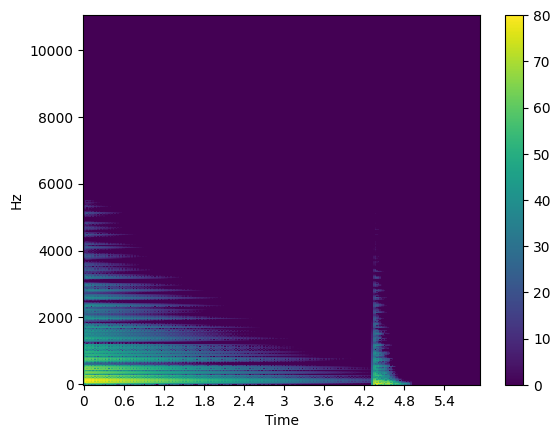

Midi audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


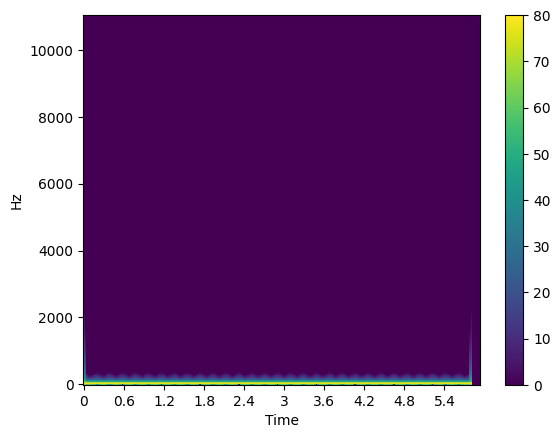

/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


Generated audio:


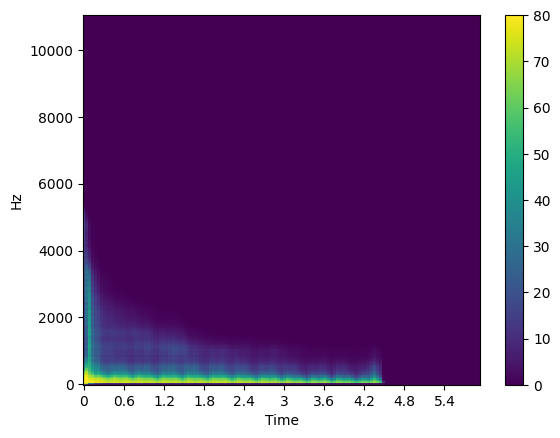

200it [00:29,  6.77it/s]
100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


In [ ]:
test_model(pix2pix_sin_sig, model_name)

# 7. **Evaluation**
Compute Frechet Audio Distance from the original audio to each of the trained models.

In [ ]:
# Using VGGISH model to extract feature
scores_vggish = {}
frechet_vggish = FrechetAudioDistance(
    model_name="vggish",
    use_pca=False,
    use_activation=False,
    verbose=False
)
for model in models:
  fad_score = frechet_vggish.score("original", f"output_{model}", dtype="float32")
  scores_vggish[model] = fad_score
  print(model, fad_score)


# Using PANN model to extract feature
scores_pann = {}
frechet_pann = FrechetAudioDistance(
    model_name="pann",
    use_pca=False,
    use_activation=False,
    verbose=False
)

for model in models:
  fad_score = frechet_pann.score("original", f"output_{model}", dtype="float32")
  scores_pann[model] = fad_score
  print(model, fad_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:03<00:00, 87.0MB/s]
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish_pca_params-970ea276.pth" to /root/.cache/torch/hub/checkpoints/vggish_pca_params-970ea276.pth
100%|██████████| 177k/177k [00:00<00:00, 8.17MB/s]


sawtooth_tanh 2.383075934622717
sawtooth_sigmoid 3.326423861528399
sinewave_tanh 5.2038635862211
sinewave_sigmoid 8.51777769250301


100%|██████████| 342M/342M [03:51<00:00, 1.55MB/s]


sawtooth_tanh 0.0010963800818807046
sawtooth_sigmoid 0.0003121512085139666
sinewave_tanh 0.0003742464646914745
sinewave_sigmoid 9.160885703804467e-05


# 8. **Best Model Listening**
Listen to generated audio from best models for each metric.

Audio 8.wav (0/200)
Original audio:


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


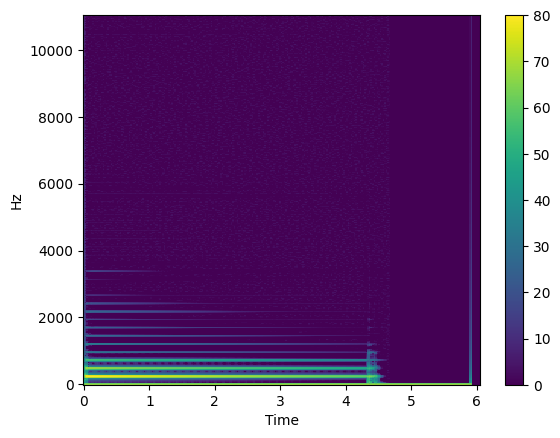

Generated audio using sawtooth_tanh (best model VGGISH metric):


/usr/local/lib/python3.10/dist-packages/librosa/display.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return mcm.get_cmap(cmap_seq)


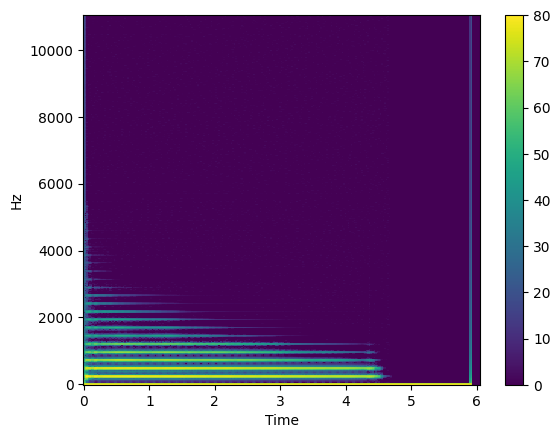

Generated audio using sinewave_sigmoid (best model PANN metric):


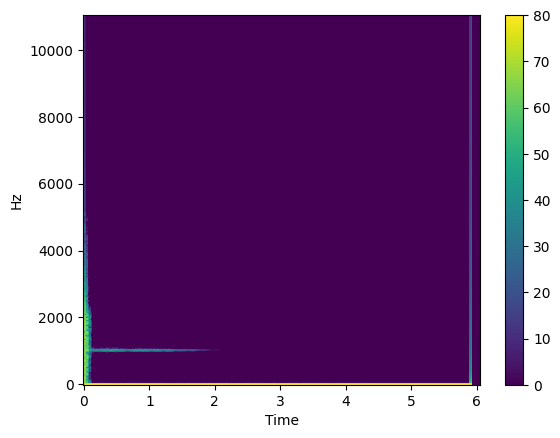

Button(description='Next audio', style=ButtonStyle())

In [ ]:
# Get best model for each metric
best_model_vggish = min(scores_vggish, key=scores_vggish.get)
best_model_pann = min(scores_pann, key=scores_pann.get)
# Get list of files
audio_files = os.listdir("original")
random.shuffle(audio_files)
i = 0

def next_audio(arg):
  global i
  # Clear output
  clear_output(wait=True)
  print(f"Audio {audio_files[i]} ({i}/{len(audio_files)})")
  # Original audio
  print("Original audio:")
  orig_wav = load_audio(audio_files[i], custom_path="original/")
  orig_spec, orig_phase = audioT.wav_to_spec(orig_wav)
  show_spec_and_audio(orig_spec, orig_phase)
  # Generated audio best vggish
  print(f"Generated audio using {best_model_vggish} (best model VGGISH metric):")
  generated_wav_vggish = load_audio(audio_files[i], custom_path=f"output_{best_model_vggish}/")
  generated_spec_vggish, generated_phase_vggish = audioT.wav_to_spec(generated_wav_vggish)
  show_spec_and_audio(generated_spec_vggish, generated_phase_vggish)
  # Generated audio best PANN
  print(f"Generated audio using {best_model_pann} (best model PANN metric):")
  generated_wav_pann = load_audio(audio_files[i], custom_path=f"output_{best_model_pann}/")
  generated_spec_pann, generated_phase_pann = audioT.wav_to_spec(generated_wav_pann)
  show_spec_and_audio(generated_spec_pann, generated_phase_pann)
  # Next audio
  i += 1
  # Buttons
  if i == len(audio_files):
    button_next = widgets.Button(description = 'Restart from first audio')
  else:
    button_next = widgets.Button(description = 'Next audio')
  button_next.on_click(next_audio)
  display(button_next)

next_audio(None)